In [1]:
# standard project preamble
from pathgen.utils.seeds import set_seed
from pathgen.utils.paths import project_root

experiment_name = "new"
experiment_root = project_root() / "experiments" / experiment_name

global_seed = 987654321
set_seed(global_seed)

In [2]:
# standard data science imports
import numpy as np

# standard pytorch imports
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# pytorch data loading imports
from torch.utils.data import DataLoader, RandomSampler
from torchvision.datasets import ImageFolder

# torchvision
import torchvision
import torchvision.transforms as transforms

In [3]:
# define our hyper parameters
batch_size = 64
num_epochs = 10
learning_rate = 0.01  # 0.001 - takes 25mins (log10 grid search?)

In [4]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# set up the data loaders for training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # these values are what the pretrained models expect
])

train_set = ImageFolder(experiment_root / 'fake_patches', transform=transform)  # 70,000 samples (35,000 per class) - fake
valid_set = ImageFolder(experiment_root / 'valid_patches', transform=transform)  # 30,000 samples (15,000 per class) - non-fake

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(global_seed), num_workers=32)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, worker_init_fn=np.random.seed(global_seed), num_workers=32)

In [6]:
def save_checkpoint(epoch, model, optimizer, path):
    print(f"saving checkpoint to {path}")
    state = { 'epoch': epoch, 
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict() }
    torch.save(state, path)

def load_checkpoint(model, optimizer, path):
    print("loading checkpoint")
    state = torch.load(path)
    epoch = state["epoch"]
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    return epoch, model, optimizer, loss

In [7]:
# preamble
from torchinfo import summary

# get and example image from the dataset so we can generate the summaries
img, _ = train_set[0]
img = img.to(device)

In [8]:
model_resnet18 = torchvision.models.resnet18(pretrained=False)
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
model_resnet18.fc = nn.Sequential(nn.Linear(in_features=512, out_features=2, bias=True))

# get a summary of the model based on our input shape
model_resnet18.to(device)
input_size = tuple([batch_size]) + tuple(img.shape)
summary(model_resnet18, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [64, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [64, 64, 32, 32]          128
├─ReLU: 1-3                              [64, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [64, 64, 16, 16]          --
├─Sequential: 1-5                        [64, 64, 16, 16]          --
│    └─BasicBlock: 2-1                   [64, 64, 16, 16]          --
│    │    └─Conv2d: 3-1                  [64, 64, 16, 16]          36,864
│    │    └─BatchNorm2d: 3-2             [64, 64, 16, 16]          128
│    │    └─ReLU: 3-3                    [64, 64, 16, 16]          --
│    │    └─Conv2d: 3-4                  [64, 64, 16, 16]          36,864
│    │    └─BatchNorm2d: 3-5             [64, 64, 16, 16]          128
│    │    └─ReLU: 3-6                    [64, 64, 16, 16]          --
│

In [10]:
from statistics import mean

class LoggedVariable:
    def __init__(self):
        self.batch_values = []
        self.epoch_values = []
        
    def append(self, value):
        self.batch_values.append(value)
        
    def end_epoch(self):
        mean_batch_values = mean(self.batch_values)
        self.epoch_values.append(mean_batch_values)
        self.batch_values = []
        
class Logger:
    def __init__(self):
        self.variables = {}
    
    def __call__(self, key, value):
        if key not in self.variables:
            self.variables[key] = LoggedVariable()
        self.variables[key].append(value)
    
    def end_epoch(self, epoch):
        print(f"end epoch {epoch}", end = '')
        for key, val in self.variables.items():
            val.end_epoch()
            print(f" {key}: {val.epoch_values[epoch]:.2f}", end = '')
        print()
    
    def history(self):
        return { k:v.epoch_values for k, v in self.variables.items() }

In [11]:
def accuracy(logits, y):
    pred = torch.log_softmax(logits, dim=1)
    correct = pred.argmax(dim=1).eq(y).sum().item()
    total = len(y)
    acc = correct / total
    return acc

In [12]:
from time import time
import json

model = model_resnet18

print(f'fitting model: {type(model).__name__} for {num_epochs} epochs.')

# set up the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

# initalise stats
log = Logger()
start_time_sec = time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    
    # train and evaluate on the training set
    model.train()
    for batch_idx, (X, y) in enumerate(train_loader):
        # put X and y for the batch on the GPU is possible
        X = X.to(device)
        y = y.to(device)

        # forward pass
        logits = model(X)
        loss = criterion(logits, y)

        # backwards pass
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()

        # log the metrics
        acc = accuracy(logits, y)
        log('train_acc', acc)
        log('train_loss', loss.item())

        print('\r', f'train.\t\tepoch: {epoch}\tbatch: {batch_idx + 1}/{len(train_loader)}\tloss: {loss:.3f}\taccuracy: {acc:.3f} ', sep='', end='', flush=True)
        # print(torch.log_softmax(logits, dim=1).argmax(dim=1), y)
        # print(f'train.\t\tepoch: {epoch}\tbatch: {batch_idx + 1}/{len(train_loader)}\tloss: {loss:.3f}\taccuracy: {acc:.3f}')
    print()

    # evaluate on the validation set
    model.eval()
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(valid_loader):
            # put X and y for the batch on the GPU is possible
            X = X.to(device)
            y = y.to(device)

            # forward pass
            logits = model(X)
            loss = criterion(logits, y)

            # computer the metric and log them
            acc = accuracy(logits, y)
            log('valid_acc', acc)
            log('valid_loss', loss.item())

            print('\r', f'validate.\tepoch: {epoch}\tbatch: {batch_idx + 1}/{len(valid_loader)}\t\tloss: {loss:.3f}\taccuracy: {acc:.3f} ', sep='', end='', flush=True)        

    print()

    save_checkpoint(epoch, model, optimizer, experiment_root / f"{type(model).__name__}_fakedata_checkpoint_{epoch}.ckpt") 
    log.end_epoch(epoch)

    scheduler.step()
    print()

end_time_sec       = time()
total_time_sec     = end_time_sec - start_time_sec
time_per_epoch_sec = total_time_sec / num_epochs
print("training complete.")
print('Time total:     %5.2f sec' % (total_time_sec))
print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))
print()

history = log.history()

# save the results
json.dump(history, open(experiment_root / f"results_{type(model).__name__}_fakedata.json", "w"))

fitting model: ResNet for 10 epochs.
Epoch 0
train.		epoch: 0	batch: 1094/1094	loss: 0.000	accuracy: 1.000 
validate.	epoch: 0	batch: 469/469		loss: 1.184	accuracy: 0.479 
saving checkpoint to /home/ubuntu/pathgen/experiments/new/ResNet_fakedata_checkpoint_0.ckpt
end epoch 0 train_acc: 0.98 train_loss: 0.04 valid_acc: 0.55 valid_loss: 0.95

Epoch 1
train.		epoch: 1	batch: 1094/1094	loss: 0.000	accuracy: 1.000 
validate.	epoch: 1	batch: 469/469		loss: 0.798	accuracy: 0.667 
saving checkpoint to /home/ubuntu/pathgen/experiments/new/ResNet_fakedata_checkpoint_1.ckpt
end epoch 1 train_acc: 1.00 train_loss: 0.00 valid_acc: 0.64 valid_loss: 0.88

Epoch 2
train.		epoch: 2	batch: 1094/1094	loss: 0.000	accuracy: 1.000 
validate.	epoch: 2	batch: 469/469		loss: 0.930	accuracy: 0.604 
saving checkpoint to /home/ubuntu/pathgen/experiments/new/ResNet_fakedata_checkpoint_2.ckpt
end epoch 2 train_acc: 1.00 train_loss: 0.00 valid_acc: 0.60 valid_loss: 0.90

Epoch 3
train.		epoch: 3	batch: 1094/1094	los

In [13]:
# test
test_set = ImageFolder(experiment_root / 'test_patches', transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, worker_init_fn=np.random.seed(global_seed), num_workers=32)

expected, predicted = [], []

# evaluate on the test set
model.eval()
with torch.no_grad():
    for batch_idx, (X, y) in enumerate(test_loader):
        # put X and y for the batch on the GPU is possible
        X = X.to(device)
        y = y.to(device)

        # forward pass
        logits = model(X)

        # computer the metric and log them
        pred = torch.log_softmax(logits, dim=1).argmax(dim=1)
        predicted.extend(pred.cpu().tolist())
        expected.extend(y.cpu().tolist())

              precision    recall  f1-score   support

      normal       0.60      0.56      0.58     15000
       tumor       0.59      0.63      0.61     15000

    accuracy                           0.60     30000
   macro avg       0.60      0.60      0.60     30000
weighted avg       0.60      0.60      0.60     30000



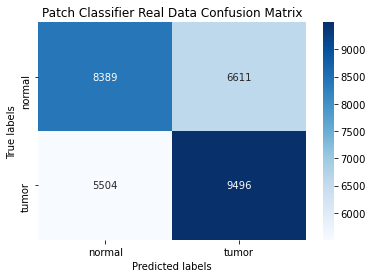

In [14]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

print(metrics.classification_report(expected, predicted, labels=[0, 1], target_names=['normal', 'tumor']))

cm = metrics.confusion_matrix(expected, predicted)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Patch Classifier Real Data Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'tumor']); ax.yaxis.set_ticklabels(['normal', 'tumor']);